# Multilayered Neural Network


#### Implemented a set of functions for training and testing a multilayered neural network to predict continuous-valued target values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# Common Functions

In [2]:
def calc_standardize_parameters(X, T):
    Xmeans = X.mean(axis=0)
    Xstds = X.std(axis=0)
    Tmeans = T.mean(axis=0)
    Tstds = T.std(axis=0)
    return {'Xmeans': Xmeans, 'Xstds': Xstds,
            'Tmeans': Tmeans, 'Tstds': Tstds}

def standardize_X(X, stand_parms):
    return (X - stand_parms['Xmeans']) / stand_parms['Xstds']


def unstandardize_X(Xst, stand_parms):
    return Xst * stand_parms['Xstds'] + stand_parms['Xmeans']


def standardize_T(T, stand_parms):
    return (T - stand_parms['Tmeans']) / stand_parms['Tstds']


def unstandardize_T(Tst, stand_parms):
    return Tst * stand_parms['Tstds'] + stand_parms['Tmeans']

# Part One

---
### ( add_ones,&nbsp;&nbsp; make_weights,&nbsp;&nbsp; rmse ) 
`These are common for Part One and Part Two`
 
---

In [3]:
def add_ones(X):
    return np.insert(X, 0, 1, axis=1)

def make_weights(n_inputs, n_hiddens_list, n_outputs):
    Ws = []
    inputs = n_inputs
    
    # Weights for the hidden units
    for h in n_hiddens_list:
        hidden_weights = np.random.uniform(-1, 1, size=(inputs + 1, h)) / np.sqrt(inputs + 1)
        inputs = h
        Ws.append(hidden_weights)
        
    # Weights for the output layer
    output_weights = np.random.uniform(-1, 1, size=(inputs + 1, n_outputs)) / np.sqrt(inputs + 1)
    Ws.append(output_weights) 
    
    return Ws

def rmse(Y, T):
    error = T - Y
    return np.sqrt(np.mean(error ** 2))

---
### ( forward,&nbsp;&nbsp;  backward, &nbsp;&nbsp; train_sgd,&nbsp;&nbsp;  use )

---

In [4]:
def forward(Xst, Ws):
    Yst = []
    Z = Xst
    
    # Ouput for hidden layers
    for w in Ws[:-1]:
        Z = np.tanh(add_ones(Z) @ w)
        Yst.append(Z)
        
    # Calculate the outputs, Y, of all output units, given all outputs of the hidden units.
    output_Y = add_ones(Z) @ Ws[-1]
    Yst.append(output_Y) 
   
    return Yst

def backward(Xst, Tst, Ws): 
    
    n_samples = Xst.shape[0]
    n_outputs = Tst.shape[1]
   
    gradients = []
    Yst = forward(Xst, Ws)
    Y = Yst[-1]   
    Z = Yst[:-1]         
   
    # Delta and gradient for the output layer
    delta = -(Tst - Y) /  (n_samples * n_outputs)
    grad_W = add_ones(Z[-1]).T @ delta
    gradients.append(grad_W)
    
    # Back-propogate delta to hidden units through output value weights 
    for i, w in zip(range(len(Z)-1, -1, -1), reversed(Ws[1:])): 
        delta = (delta @ w[1:, :].T) * (1 - Z[i] ** 2)
        if(i != 0):
            grad_V = add_ones(Z[i-1]).T @ delta
        else:
            grad_V = add_ones(Xst).T @ delta
        gradients.append(grad_V)
    
    return gradients[::-1] 

def train_sgd(X, T, Ws, learning_rate, n_epochs):
    
    # Standardize X and T
    stand_parms = calc_standardize_parameters(X, T)
    Xst = standardize_X(X, stand_parms)
    Tst = standardize_T(T, stand_parms)

    error_trace = []
    

    # Update weights for n_epochs passes through the training data
    for epoch in range(n_epochs):

        # Calculate the gradients of the mean squared error with respect to each weight matrix.
        gradient = backward(Xst, Tst, Ws)

        # Update the values in each weight matrix using SGD.
        for g,w in zip(gradient, Ws):
            w -= learning_rate * g

        # Calculate the outputs of both layers given the current weight values.
        Yst = forward(Xst, Ws)
        Y = unstandardize_T(Yst[-1], stand_parms)
        error_trace.append(rmse(Y, T))

    return Ws, stand_parms, error_trace

def use(X, Ws, stand_parms):
    Xst = standardize_X(X, stand_parms)
    Yst = forward(Xst, Ws)
    Yst[-1] =  unstandardize_T(Yst[-1], stand_parms)     # Unstandardizing the last layer output
    return Yst

### Loop to print the dataframe
`Used for Part One and Two as well`

In [5]:
np.random.seed(42)
def print_df(Xtrain, hidden_layers, Ttrain, activation_func):
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    results = []
    n_epochs = 10000
    learning_rate = 0.1
    
    # Loop through hidden layers
    for h in hidden_layers:        
        Ws = make_weights(n_inputs, h, n_outputs)
        
        if(activation_func == 'tanh'):
            Ws, stand_parms, error_trace = train_sgd(Xtrain, Ttrain, Ws, learning_rate, n_epochs)
            Ytrain = use(Xtrain, Ws, stand_parms)
            rmse_train = rmse(Ytrain[-1], Ttrain)
            Ytest = use(Xtest, Ws, stand_parms)
            rmse_test = rmse(Ytest[-1], Ttest)
        else:
            Ws, stand_parms, error_trace = train_sgd_asig(Xtrain, Ttrain, Ws, learning_rate, n_epochs)
            Ytrain = use_asig(Xtrain, Ws, stand_parms)
            rmse_train = rmse(Ytrain[-1], Ttrain)
            Ytest = use_asig(Xtest, Ws, stand_parms)
            rmse_test = rmse(Ytest[-1], Ttest)
            
        
        results.append([len(h),rmse_train,rmse_test])
    
    df = pandas.DataFrame(results, columns=('Layers', 'RMSE Train', 'RMSE Test'))
    
    return df

## Code used to Plot

In [6]:
def plot_output1(W):
    
    n_epochs = 10000
    learning_rate = 0.1
    Ws, stand_parms, error_trace = train_sgd(Xtrain, Ttrain, W, learning_rate, n_epochs)

    
    fig1 = plt.figure(1,figsize=(12, 12))
    
    # For RMSE vs Epoch
    ax1 = fig1.add_subplot(3,1,1)
    ax1.plot(error_trace)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('RMSE')
    
    # For Neural Net Output
    ax1 = fig1.add_subplot(3, 1, 2)
    ax1.plot(Xtrain, Ttrain, 'o', label='Training Data')
    ax1.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y = use(X_for_plot, Ws, stand_parms)
    plt.plot(X_for_plot, Y[-1], label='Neural Net Output')
    ax1.legend()
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # For Hidden Layer Outputs
    if(len(Y[:-1]) == 1):
        fig2 = plt.figure(2,figsize=(12, 6))
        ax2 = fig2.add_subplot(1,1,1)
        ax2.plot(X_for_plot, Y[0])
        ax2.set_xlabel('X')
        ax2.set_ylabel('Hidden Unit Output')
    else:
        fig2 = plt.figure(2,figsize=(12,12))
        for i in range(len(Y[:-1])):
            ax2 = fig2.add_subplot(len(Y[:-1]), 1, i+1)
            ax2.plot(X_for_plot, Y[i])
            ax2.set_xlabel('X')
            ax2.set_ylabel('Hidden Unit %s Output' %(i+1))
    
    

### One-dimensional Input

In [7]:
np.random.seed(42)
n_samples = 30

Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

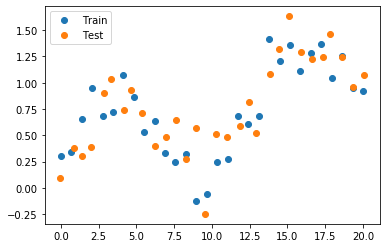

In [8]:
plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.plot(Xtest, Ttest, 'o', label='Test')
plt.legend();

### Output and Plots for `one` hidden layer
Hidden Units = 10

In [9]:
n_inputs = Xtrain.shape[1]
n_hiddens = [10]
n_outputs = Ttrain.shape[1]

Ws = make_weights(n_inputs, n_hiddens, n_outputs)

### `Output:`

In [10]:
print_df(Xtrain,[n_hiddens],Ttrain,'tanh')

,Layers,RMSE Train,RMSE Test
0,1,0.142933,0.222606


### `Plot:`

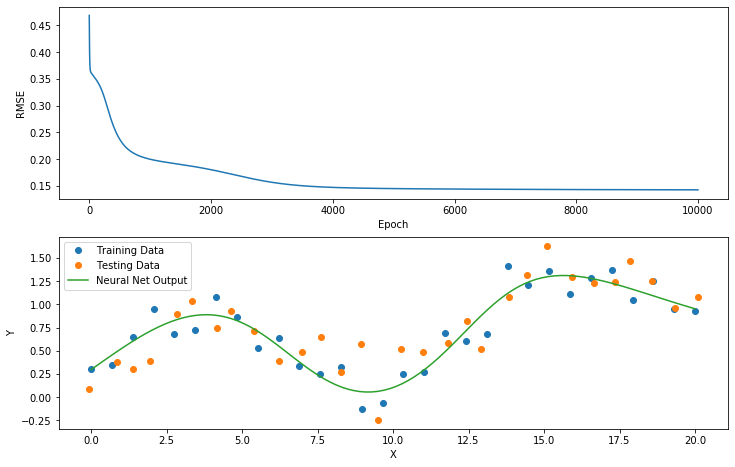

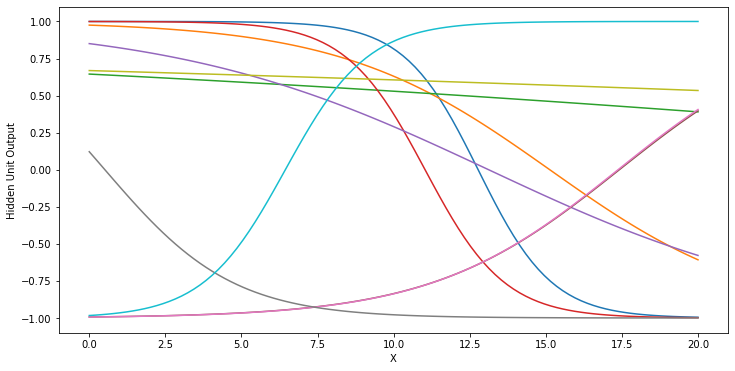

In [11]:
plot_output1(Ws)

### Output and Plots for `two` hidden layers
Hidden Units = [10, 10]

In [12]:
n_inputs = Xtrain.shape[1]
n_hiddens = [10,10]
n_outputs = Ttrain.shape[1]

Ws = make_weights(n_inputs, n_hiddens, n_outputs)

### `Output:`

In [13]:
print_df(Xtrain,[n_hiddens],Ttrain,'tanh')

,Layers,RMSE Train,RMSE Test
0,2,0.137741,0.220249


### `Plots:`

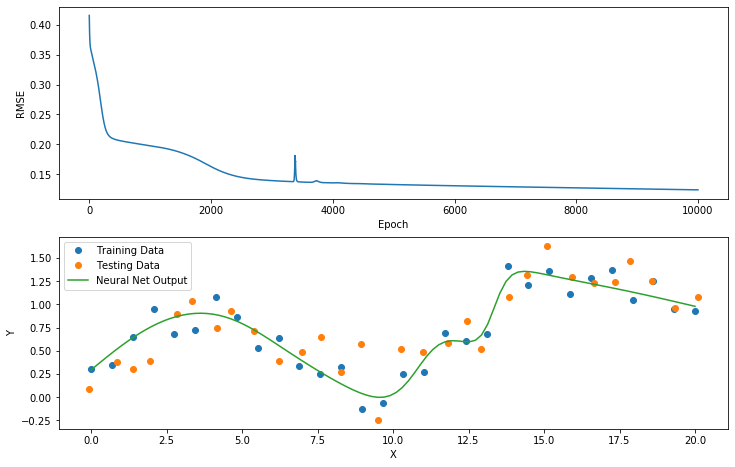

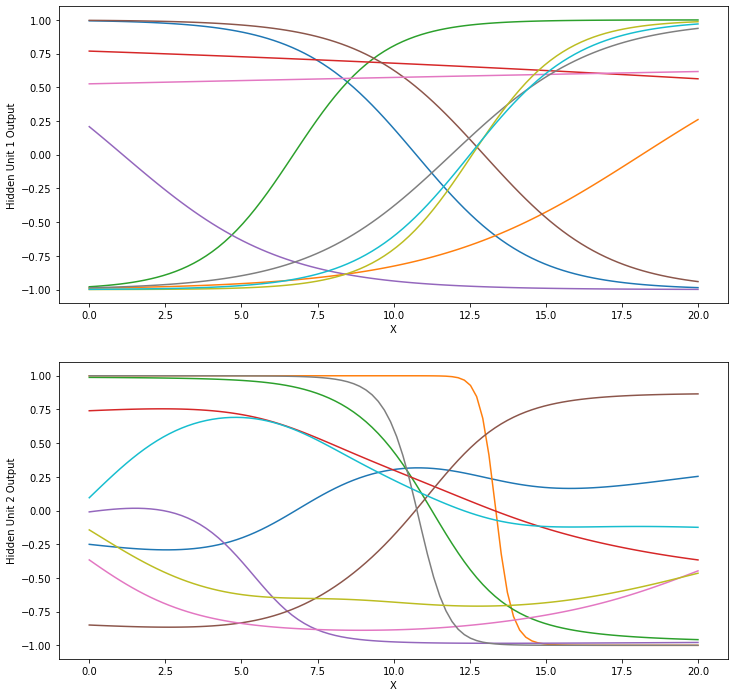

In [14]:
plot_output1(Ws)

### Dataframe for trained neural nets containing one, two, three and four hidden layers each with 4 hidden units
`Epoch = 10000, learning rate = 0.1`

In [15]:
n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]
hidden_layers = [[4],[4,4],[4,4,4],[4,4,4,4]]
print_df(Xtrain, hidden_layers, Ttrain, 'tanh')

,Layers,RMSE Train,RMSE Test
0,1,0.171560,0.253723
1,2,0.167748,0.254508
2,3,0.141842,0.224754
3,4,0.256534,0.262273


# Discussion

`All the experiments were conducted using a learning rate of 0.1 and 10000 epochs`
<br>
1. Looking at plot of the output of one hidden layer with 10 units, we can see that the model does a good job at fitting the data with a Test RMSE of **0.222606**
<br>
2. The plot for the two hidden layers with 10 units each show a very small change in its performance than the previous one with a Test RMSE of **0.220249** 
<br>
3. The table for the different hidden layers as shown above shows several different values.
    > a. The output with one, two and four hidden layers do not show great Test RMSE. They are all above 0.25
    <br>
    > b. It seems like the experiment with 3 hidden layers gave the best results for both train and test with a RMSE value of 0.142 and 0.2247 respectively
     <br>
    > c. Looking at the model and RMSE values, this model seems like a good fit for this linear data. Experimenting with higher units and layers might help us understand if there's a better fit
     <br>

# Part Two


---
`( forward_asig, backward_asig, train_sgd_asig, use_asig )`

---

In [16]:


def forward_asig(Xst, Ws):
    Yst = []
    Z = Xst
    
    # Ouput for hidden layers
    for w in Ws[:-1]:
        Z = sigmoid(add_ones(Z) @ w)
        Yst.append(Z)
        
    # Calculate the outputs, Y, of all output units, given all outputs of the hidden units.
    output_layer = add_ones(Z) @ Ws[-1]
    Yst.append(output_layer)
    
    return Yst

def backward_asig(Xst, Tst, Ws): 
    n_samples = Xst.shape[0]
    n_outputs = Tst.shape[1]
    gradients = []

    Yst = forward_asig(Xst, Ws)
    Y = Yst[-1]          
    Z = Yst[:-1]         
    
    # Delta and gradient for the output layer
    delta = -(Tst - Y) /  (n_samples * n_outputs)
    grad_W = add_ones(Z[-1]).T @ delta
    gradients.append(grad_W)

    # Back-propogate delta to hidden units through output value weights 
    for i, w in zip(range(len(Z)-1, -1, -1), reversed(Ws[1:])): 
        delta = (delta @ w[1:, :].T) * (Z[i] * (1 - Z[i]))
        if(i != 0):
            grad_v = add_ones(Z[i-1]).T @ delta
        else:
            grad_v = add_ones(Xst).T @ delta  
        gradients.append(grad_v)
    
    return gradients[::-1]

def train_sgd_asig(X, T, Ws, learning_rate, n_epochs):
    # Standardize X and T
    stand_parms = calc_standardize_parameters(X, T)
    Xst = standardize_X(X, stand_parms)
    Tst = standardize_T(T, stand_parms)

    error_trace = []
    
    # Update weights for n_epochs passes through the training data
    for epoch in range(n_epochs):
        
        # Calculate the gradients of the mean squared error with respect to each weight matrix.
        gradient = backward_asig(Xst, Tst, Ws)
        
        # Update the values in each weight matrix using SGD.
        for g,w in zip(gradient, Ws):
            w -= learning_rate * g
        
        # Calculate the outputs of both layers given the current weight values.
        Yst = forward_asig(Xst, Ws)
        Y = unstandardize_T(Yst[-1], stand_parms)
        error_trace.append(rmse(Y, T))

    return Ws, stand_parms, error_trace

def use_asig(X, Ws, stand_parms):
    Xst = standardize_X(X, stand_parms)
    Yst = forward_asig(Xst, Ws)
    Yst[-1] =  unstandardize_T(Yst[-1], stand_parms)     # Unstandardizing the last layer output
    return Yst

def sigmoid(x):
    return 1/(1 + np.exp(-x))

## Code  to Plot Sigmoid Output

In [17]:
def plot_output2(W):
    
    n_epochs = 10000
    learning_rate = 0.1
    Ws, stand_parms, error_trace = train_sgd_asig(Xtrain, Ttrain, W, learning_rate, n_epochs)
    
 
    fig1 = plt.figure(1,figsize=(12, 12))
    
    # For RMSE vs Epoch
    ax1 = fig1.add_subplot(3,1,1)
    ax1.plot(error_trace)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('RMSE')
    
    # For Neural Net Output
    ax1 = fig1.add_subplot(3, 1, 2)
    ax1.plot(Xtrain, Ttrain, 'o', label='Training Data')
    ax1.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y = use_asig(X_for_plot, Ws, stand_parms)
    plt.plot(X_for_plot, Y[-1], label='Neural Net Output')
    ax1.legend()
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # For hidden layer outputs
    if(len(Y[:-1]) == 1):
        fig2 = plt.figure(2,figsize=(12, 6))
        ax2 = fig2.add_subplot(1,1,1)
        ax2.plot(X_for_plot, Y[0])
        ax2.set_xlabel('X')
        ax2.set_ylabel('Hidden Unit Output')
    else:
        fig2 = plt.figure(2,figsize=(12,12))
        for i in range(len(Y[:-1])):
            ax2 = fig2.add_subplot(len(Y[:-1]), 1, i+1)
            ax2.plot(X_for_plot, Y[i])
            ax2.set_xlabel('X')
            ax2.set_ylabel('Hidden Unit %s Output' %(i+1))
    
    

### One-dimensional Input

In [18]:
np.random.seed(42)
n_samples = 30

Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

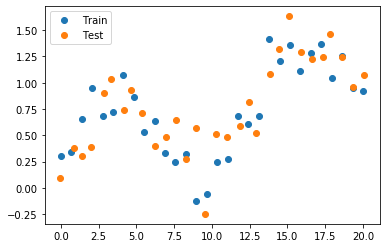

In [19]:
plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.plot(Xtest, Ttest, 'o', label='Test')
plt.legend();

### Output and Plots for `one` hidden layer with Sigmoid
Hidden Units = 10

In [20]:
n_inputs = Xtrain.shape[1]
n_hiddens = [10]
n_outputs = Ttrain.shape[1]

Ws = make_weights(n_inputs, n_hiddens, n_outputs)

### `Output:`

In [21]:
print_df(Xtrain,[n_hiddens],Ttrain,'sigmoid')

,Layers,RMSE Train,RMSE Test
0,1,0.188521,0.265979


### `Plots:`

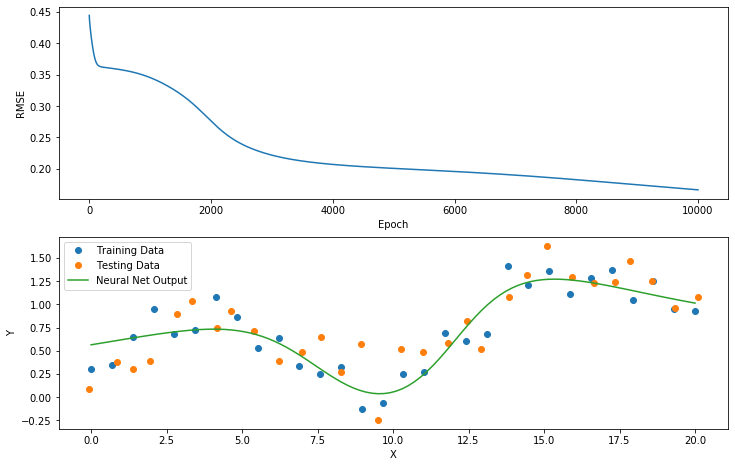

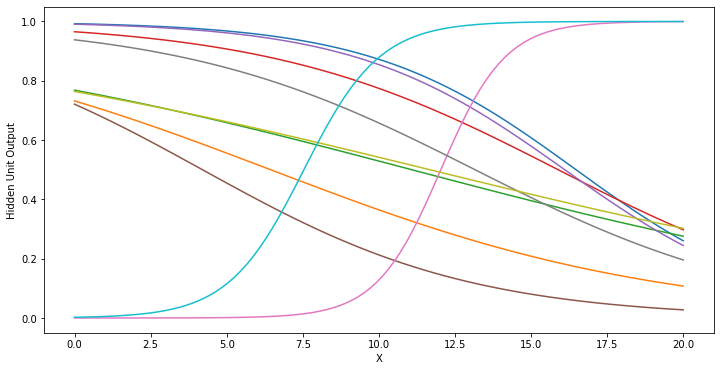

In [22]:
plot_output2(Ws)

### Output and Plots for `two` hidden layers with Sigmoid


In [23]:
n_inputs = Xtrain.shape[1]
n_hiddens = [10,10]
n_outputs = Ttrain.shape[1]

Ws = make_weights(n_inputs, n_hiddens, n_outputs)

### `Output:`

In [24]:
print_df(Xtrain,[n_hiddens],Ttrain,'sigmoid')

,Layers,RMSE Train,RMSE Test
0,2,0.193773,0.274041


### `Plots:`

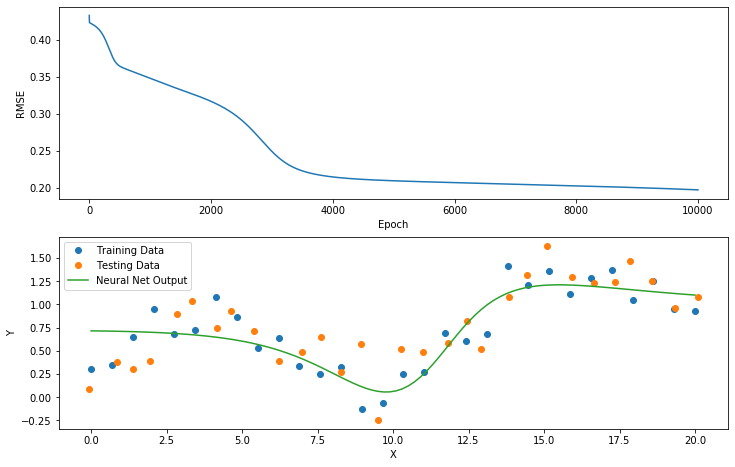

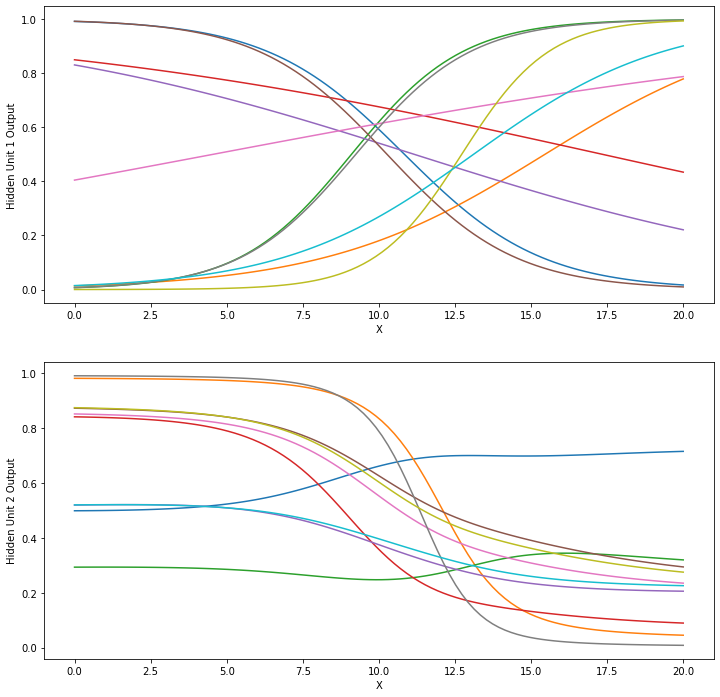

In [25]:
plot_output2(Ws)

### Dataframe for trained neural nets containing one, two, three and four hidden layers each with 4 hidden units
`Epoch = 10000, learning rate = 0.1`

In [26]:
n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]
hidden_layers = [[4],[4,4],[4,4,4],[4,4,4,4]]
print_df(Xtrain, hidden_layers, Ttrain, 'sigmoid')

,Layers,RMSE Train,RMSE Test
0,1,0.191442,0.273794
1,2,0.200367,0.279016
2,3,0.274474,0.270122
3,4,0.422577,0.433471


# Discussion for Sigmoid

`All the experiments were conducted using a learning rate of 0.1 and 10000 epochs`
<br>
1. Looking at plot of the output of one hidden layer with 10 units, we can see that the model does an okay job at fitting the data with a Test RMSE of **0.265**
<br>
2. The plot for the two hidden layers with 10 units each show a very small change in its performance than the previous one with a Test RMSE of **0.27** 
<br>
3. The table for the different hidden layers as shown above shows several different values.
    > a. The output with two, three and four hidden layers do not show great Test RMSE. They are all above 0.25. In fact the four layer output is reach 0.4 RMSE
    <br>
    > b. It seems like the experiment with 1 hidden layers gave the best results for both train and test with a RMSE value of 0.191 and 0.273 respectively
     <br>
    > c. Looking at the model and RMSE values, this model seems like an okay fit for this linear data. As the hidden layers increase, even the RMSE seems to increase.
     <br>
    > d. It also seems like tanh does a better job for this particular data than sigmoid.
    <br>
    > e. tanh worst results seem near to sigmoid's best results. 
    <br>
    > f. Looking at this asymmetric activation fucntion might not be a great choice for these kind of data.